## Step 0: Importamos librerias y el dataset

In [1]:
# Importamos librerias
import pandas as pd
import numpy as np
import datetime as dt
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from google.cloud import bigquery
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')

In [2]:
import kfp
from google.cloud import aiplatform
from google_cloud_pipeline_components.v1.dataset import ImageDatasetCreateOp
from google_cloud_pipeline_components.v1.endpoint import EndpointCreateOp, ModelDeployOp
import joblib

    

In [3]:
!pip install google_cloud_pipeline_components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-python-client 1.8.0 requires google-api-core<2dev,>=1.13.0, but you have google-api-core 2.19.1 which is incompatible.
google-cloud-datastore 1.15.5 requires protobuf<4.0.0dev, but you have protobuf 4.25.5 which is incompatible.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [4]:
pip show scikit-learn

Name: scikit-learn
Version: 1.5.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /opt/conda/lib/python3.10/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: pmdarima
Note: you may need to restart the kernel to use updated packages.


In [5]:
%%bigquery us_retail
SELECT Month, FoodAndBeverage, Automobiles
FROM demoespecialidadgcp.demo_ts.us_retail;

Query is running:   0%|          |

Downloading:   0%|          |

Realizamos un split entre datos de testeo y entrenamiento y las guardamos en archivos .csv

In [6]:
train, test = train_test_split(us_retail, test_size=0.18, shuffle=False)

data_path = '../data/'

train.to_csv(data_path + 'train.csv')
test.to_csv(data_path + 'test.csv')

In [7]:
train

,Month,FoodAndBeverage,Automobiles
0,2017-10,60762,89438
1,2019-07,66428,100703
2,1997-12,37330,45800
3,1996-07,34426,50106
4,1998-11,34557,47787
...,...,...,...
270,1992-06,30769,34667
271,2015-11,57099,77576
272,2003-12,43265,61576
273,2008-11,47675,41843


In [8]:
test

,Month,FoodAndBeverage,Automobiles
275,2000-03,36459,69456
276,2003-10,39828,62411
277,2014-07,57477,84244
278,2011-11,51352,57102
279,2003-04,38478,66968
...,...,...,...
331,2007-07,46416,72619
332,2018-12,68047,93824
333,2000-07,38160,61915
334,1998-12,39240,49971


#### Vamos a realizar predicciones de las columnas FoodAndBeverage y Automobiles

In [9]:
industries = ['FoodAndBeverage', 'Automobiles']
retail = pd.read_csv(
    "../data/us_retail.csv",
    usecols=['Month']+ industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('M').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail = retail.sort_values('Month')
retail.head()

Sales            
Industries FoodAndBeverage Automobiles
Month                                 
1992-01              29589       26788
1992-02              28570       28203
1992-03              29682       31684
1992-04              30228       32547
1992-05              31677       32883

Realizamos un split entre datos de testeo y entrenamiento y las guardamos en archivos .csv

In [12]:
train=pd.read_csv('../data/train.csv', parse_dates=['Month'],
    index_col='Month').to_period('M').reindex(columns=industries)
train

,FoodAndBeverage,Automobiles
Month,,
2017-10,60762,89438
2019-07,66428,100703
1997-12,37330,45800
1996-07,34426,50106
1998-11,34557,47787
...,...,...
1992-06,30769,34667
2015-11,57099,77576
2003-12,43265,61576


In [13]:
test=pd.read_csv('../data/test.csv', parse_dates=['Month'],
    index_col='Month').to_period('M').reindex(columns=industries)
test

,FoodAndBeverage,Automobiles
Month,,
2000-03,36459,69456
2003-10,39828,62411
2014-07,57477,84244
2011-11,51352,57102
2003-04,38478,66968
...,...,...
2007-07,46416,72619
2018-12,68047,93824
2000-07,38160,61915


## Predecimos usando features deterministas: tendencia y estacionalidad

### Modelos hibridos

Primero vamos a utilizar un modelo de regresión lineal para conocer la tendencia de cada serie. 

MSE FoodAndBeverage: 2558.350889216423 ; MSE Automobiles: 12646.564482327209


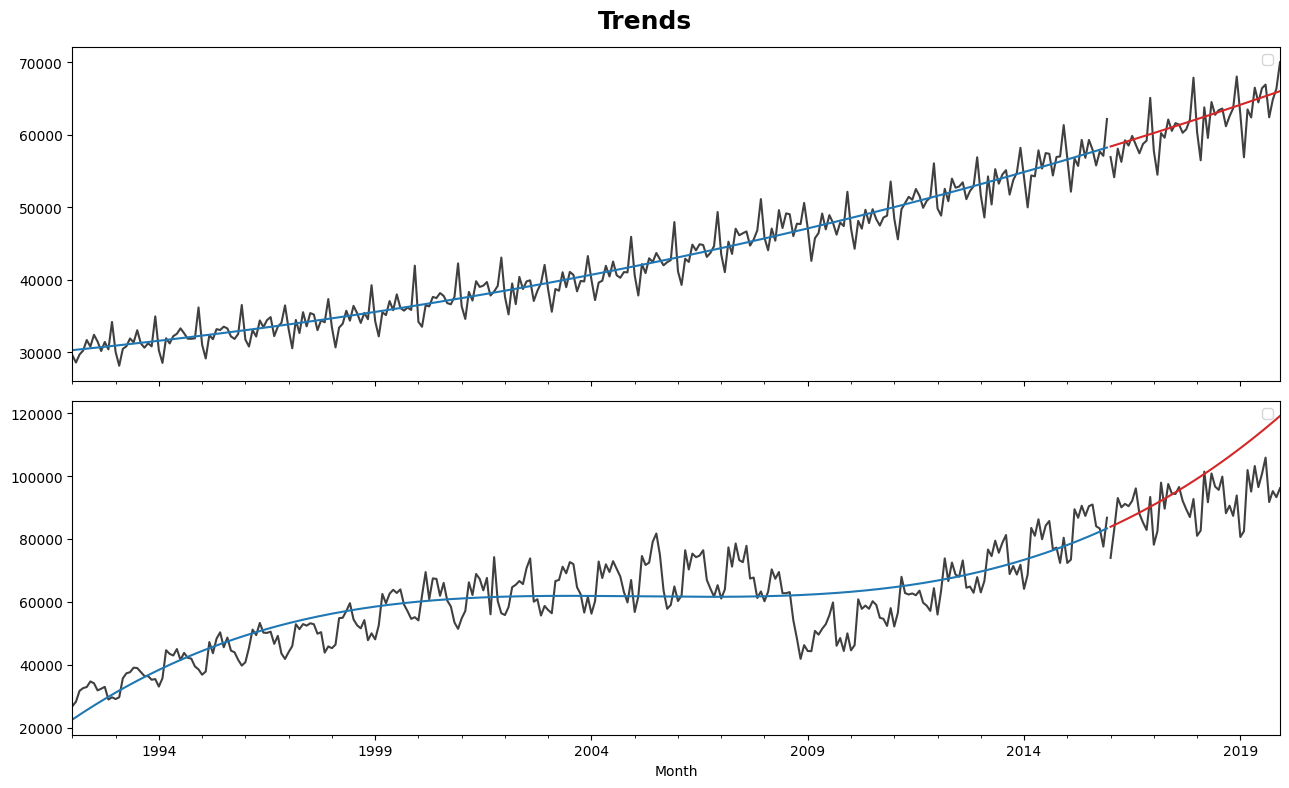

In [10]:
y = retail.copy()


# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=3,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test sobre los años 2016-2019. Será más fácil para nosotros más tarde si
# dividimos el índice de fechas en lugar del dataframe directamente.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model_1_lr = LinearRegression(fit_intercept=False)
model_1_lr.fit(X_train, y_train)

y_test = pd.DataFrame(y_test)
X_test = pd.DataFrame(X_test)

# Generamos predicciones
y_fit = pd.DataFrame(
    model_1_lr.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model_1_lr.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

y_test

#Evaluamos el modelo
mse_1_lr_food = mean_squared_error(y_test.Sales.FoodAndBeverage, y_pred.Sales.FoodAndBeverage, squared=False)
mse_1_lr_auto = mean_squared_error(y_test.Sales.Automobiles, y_pred.Sales.Automobiles, squared=False)

print(f'MSE FoodAndBeverage: {mse_1_lr_food}',f'; MSE Automobiles: {mse_1_lr_auto}' )


#plot
plt.rc(
    "figure",
    autolayout=True,
    figsize=(13, 8),
    titlesize=18,
    titleweight='bold',
)


axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: 
    ax.legend([])

_ = plt.suptitle("Trends")


Mientras que el algoritmo de regresión lineal es capaz de realizar regresiones con múltiples salidas, el algoritmo XGBoost no lo es. Para predecir múltiples series a la vez con XGBoost, en su lugar convertiremos estas series de formato ancho, con una serie temporal por columna, a formato largo, con series indexadas por categorías a lo largo de las filas.

In [11]:
# El método `stack` convierte las etiquetas de columna en etiquetas de fila, pivotando de formato ancho a largo
X = retail.stack()  # pivot dataset wide to long
display(X.head(12))
y = X.pop('Sales')  # grab target series

Sales
Month   Industries            
1992-01 FoodAndBeverage  29589
        Automobiles      26788
1992-02 FoodAndBeverage  28570
        Automobiles      28203
1992-03 FoodAndBeverage  29682
        Automobiles      31684
1992-04 FoodAndBeverage  30228
        Automobiles      32547
1992-05 FoodAndBeverage  31677
        Automobiles      32883
1992-06 FoodAndBeverage  30769
        Automobiles      34667

Para que XGBoost pueda aprender a distinguir nuestras dos series temporales, convertiremos las etiquetas de fila de "Industrias" en una característica categórica con una codificación de etiqueta. También crearemos una función para la estacionalidad anual extrayendo los números de los meses del índice temporal.

In [12]:
# Convierte las etiquetas de las filas en columnas de características categóricas con una codificación de etiquetas.

X = X.reset_index('Industries')
    # Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]


Ahora convertiremos las predicciones de tendencia realizadas anteriormente a formato largo y luego las restaremos de la serie original. Así obtendremos series sin tendencia (residuales) que XGBoost puede aprender.

In [13]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

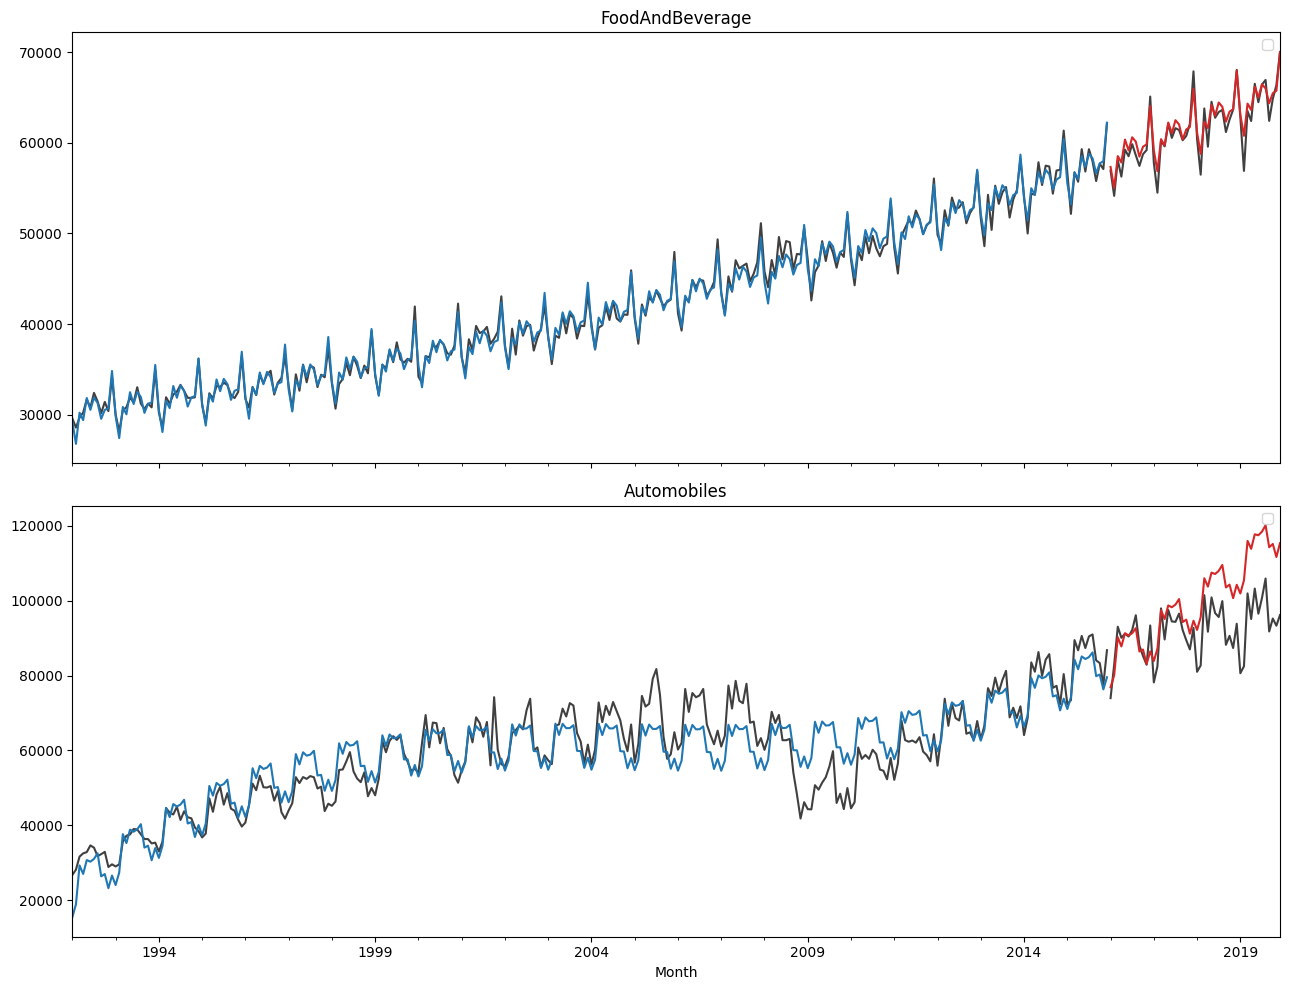

In [14]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(13, 10), subplots=True, sharex=True,
    title=['FoodAndBeverage', 'Automobiles'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

Podemos ver cómo la tendencia aprendida por XGBoost es sólo tan buena como la tendencia aprendida por la regresión lineal -- en particular, XGBoost no fue capaz de compensar la tendencia mal ajustada en la serie 'Automobiles'.

Crearemos nuestras features estacionales utilizando 'DeterministicProcess', la misma utilidad que usamos para crear features de tendencia. Para utilizar dos periodos estacionales tendremos que instanciar uno de ellos como "término adicional":

Antes realizaremos un split sobre los datos

In [38]:
#hacemos el preprocesamiento de los datos para el modelo
def prepro(f, n, y):
    fourier = CalendarFourier(freq='S', order=f)  # 5 sin/cos pairs for "S"emiannual seasonality

    dp = DeterministicProcess(
        index=y.index,
        constant=True,               # dummy feature for bias (y-intercept)
        order=n,                     # trend (order 1 means linear)
        seasonal=True,               # weekly seasonality (indicators)
        additional_terms=[fourier],  # annual seasonality (fourier)
        drop=True,                   # drop terms to avoid collinearity
    )

   # X = pd.DataFrame(dp.in_sample()) # create features for dates 
   # X_train, X_test = train_test_split(X, test_size=0.18, shuffle=False)
   # y_train, y_test = train_test_split(y, test_size=0.18, shuffle=False)
    
    return dp

In [39]:
#realizamos el split de los datos de entrenamiento y testeo
y = retail.Sales.FoodAndBeverage

dp = prepro(5,2,y)
X = pd.DataFrame(dp.in_sample()) # create features for dates 
X_train, X_test = train_test_split(X, test_size=0.18, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.18, shuffle=False)


#guardamos los conjuntos de entrenamiento y testeo en csv
data_path = '../data/'

# Convertimos a DataFrame
train = pd.DataFrame(X_train)
train['y'] = y_train

test = pd.DataFrame(X_test)
test['y'] = y_test
train.to_csv(data_path + 'train.csv')
test.to_csv(data_path + 'test.csv')

In [40]:
train

,const,trend,trend_squared,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)",y
Month,,,,,,,,,,,,,,,
1992-01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29589
1992-02,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28570
1992-03,1.0,3.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29682
1992-04,1.0,4.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30228
1992-05,1.0,5.0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-07,1.0,271.0,73441.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,57477
2014-08,1.0,272.0,73984.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,57384
2014-09,1.0,273.0,74529.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,54386


In [41]:
test

,const,trend,trend_squared,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)",y
Month,,,,,,,,,,,,,,,
2014-12,1.0,276.0,76176.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,61344
2015-01,1.0,277.0,76729.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56749
2015-02,1.0,278.0,77284.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52155
2015-03,1.0,279.0,77841.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56741
2015-04,1.0,280.0,78400.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,1.0,332.0,110224.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,66937
2019-09,1.0,333.0,110889.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,62420
2019-10,1.0,334.0,111556.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,64849


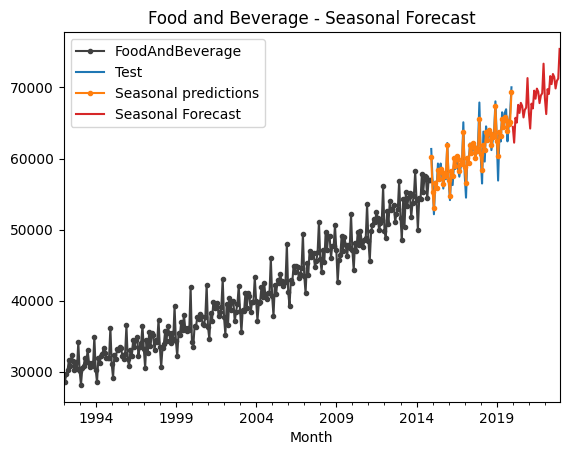

In [42]:
#inicializamos el modelo,  probando con una regresion lineal
model_lr_seasonal_food = LinearRegression(fit_intercept=False)
_ = model_lr_seasonal_food.fit(X_train, y_train)

y_pred = pd.Series(model_lr_seasonal_food.predict(X_test), index=y_test.index)
X_fore = dp.out_of_sample(steps=36)
y_fore = pd.Series(model_lr_seasonal_food.predict(X_fore), index=X_fore.index)

#plot
ax = y_train.plot(color='0.25', style='.-', title="Food and Beverage - Seasonal Forecast")
ax = y_test.plot(ax=ax, label="Test")
ax = y_pred.plot(ax=ax, label="Seasonal predictions", style='.-')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

#### Evaluamos el modelo

In [43]:
#Metrics FoodAndBeverage
rmse_seasonal_food = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
r2_seasonal_food = r2_score(y_test, y_pred)

print(f'RMSE FoodAndBeverage: {rmse_seasonal_food}')
print(f'R2 score FoodAndBeverage: {r2_seasonal_food}')

RMSE FoodAndBeverage: 31.278084993877894
R2 score FoodAndBeverage: 0.9321377560171742


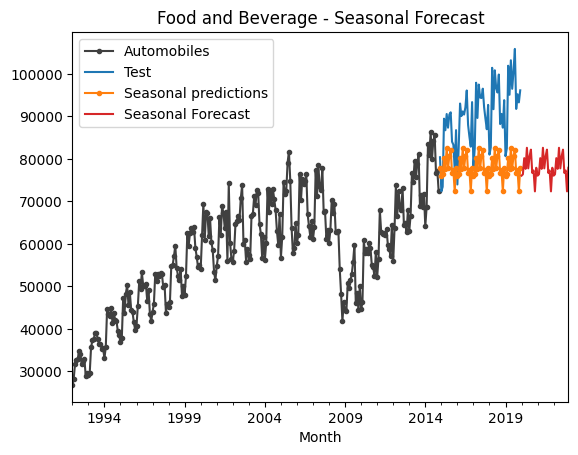

In [37]:
#inicializamos el modelo,  probando con un XGBoost regressor
model_xgb_seasonal_food = XGBRegressor()
_ = model_xgb_seasonal_food.fit(X_train, y_train)

y_pred = pd.Series(model_xgb_seasonal_food.predict(X_test), index=y_test.index)
X_fore = dp.out_of_sample(steps=36)
y_fore = pd.Series(model_xgb_seasonal_food.predict(X_fore), index=X_fore.index)

#plot
ax = y_train.plot(color='0.25', style='.-', title="Food and Beverage - Seasonal Forecast")
ax = y_test.plot(ax=ax, label="Test")
ax = y_pred.plot(ax=ax, label="Seasonal predictions", style='.-')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

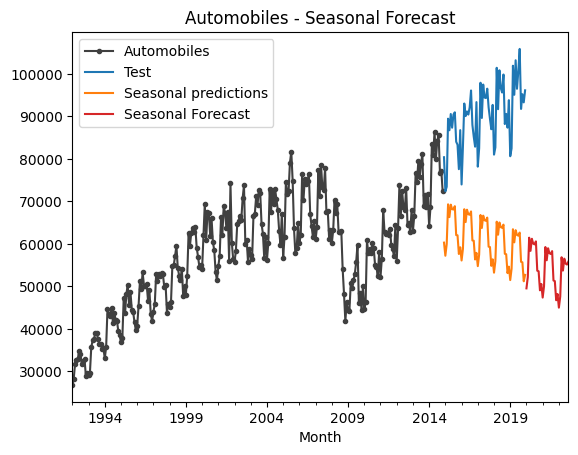

In [34]:
#realizamos el split de los datos de entrenamiento y testeo
y = retail.Sales.Automobiles

dp = prepro(5,2,y)
X = pd.DataFrame(dp.in_sample()) # create features for dates 
X_train, X_test = train_test_split(X, test_size=0.18, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.18, shuffle=False)


#Inicializamos el modelo
model_xgb_seasonal_auto = LinearRegression(fit_intercept=False)
_ = model_xgb_seasonal_auto.fit(X_train, y_train)

y_pred = pd.Series(model_xgb_seasonal_auto.predict(X_test), index=y_test.index)
X_fore_auto = dp.out_of_sample(steps=32)
y_fore = pd.Series(model_xgb_seasonal_auto.predict(X_fore_auto), index=X_fore_auto.index)

#plot
ax = y_train.plot(color='0.25', style='.-', title="Automobiles - Seasonal Forecast")
ax = y_test.plot(ax=ax, label="Test")
ax = y_pred.plot(ax=ax, label="Seasonal predictions")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()



In [30]:
#hacemos el split de los datos
y = retail.Sales.Automobiles
#train, test = train_test_split(y, test_size=0.18, shuffle=False)

X_train, X_test, y_train, y_test = prepro(5,3,y)[0],  prepro(5,3,y)[1],  prepro(5,3,y)[2],  prepro(5,3,y)[3]
dp_train = prepro(5,3,y)[4]

#Inicializamos el modelo
model_xgb_seasonal_auto = XGBRegressor(fit_intercept=False)
_ = model_xgb_seasonal_auto.fit(X_train, y_train)

y_pred = pd.Series(model_xgb_seasonal_auto.predict(X_test), index=y_test.index)
X_fore_auto = dp_train.out_of_sample(steps=32)
y_fore = pd.Series(model_xgb_seasonal_auto.predict(X_fore_auto), index=X_fore_auto.index)

#plot
ax = y_train.plot(color='0.25', style='.-', title="Automobiles - Seasonal Forecast")
ax = y_test.plot(ax=ax, label="Test")
ax = y_pred.plot(ax=ax, label="Seasonal predictions")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

TypeError: 'DeterministicProcess' object is not subscriptable

#### Evaluamos el modelo

In [31]:
#Metrics
rmse_seasonal_auto = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
r2_seasonal_auto = r2_score(y_test, y_pred)

print(f'RMSE Automobiles: {rmse_seasonal_auto}')
print(f'R2 Score Automobiles: {r2_seasonal_auto}')

RMSE Automobiles: 114.80781665716103
R2 Score Automobiles: -2.1472744941711426


### Forecasting using Lags features

In [175]:
#Metrics
rmse_seasonal_auto = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
r2_seasonal_auto = r2_score(y_test, y_pred)

print(f'RMSE Automobiles: {rmse_seasonal_auto}')
print(f'R2 Score Automobiles: {r2_seasonal_auto}')


RMSE Automobiles: 72.92332638837881
R2 Score Automobiles: -1.0050880908966064


Volviendo al gráfico de autocorrelación parcial para FoodAndBeverage, sugiere que la dependencia puede capturarse utilizando los lags 1,2,3,4,5,6,7,8,11 y 12

In [67]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [68]:
food = pd.DataFrame(retail.Sales.FoodAndBeverage)
food

,FoodAndBeverage
Month,
1992-01,29589
1992-02,28570
1992-03,29682
1992-04,30228
1992-05,31677
...,...
2019-08,66937
2019-09,62420
2019-10,64849


In [69]:
lags = np.array([1, 3, 11, 12])

food_lag = make_lags(food, lags=12)
food_lag = food_lag.fillna(0.0)
food_lag

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,y_lag_11,y_lag_12
,FoodAndBeverage,FoodAndBeverage,FoodAndBeverage,FoodAndBeverage,FoodAndBeverage,FoodAndBeverage,FoodAndBeverage,FoodAndBeverage,FoodAndBeverage,FoodAndBeverage,FoodAndBeverage,FoodAndBeverage
Month,,,,,,,,,,,,
1992-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-02,29589.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-03,28570.0,29589.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-04,29682.0,28570.0,29589.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-05,30228.0,29682.0,28570.0,29589.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,66428.0,64479.0,66510.0,62402.0,63504.0,56898.0,62829.0,68047.0,63656.0,62554.0,61186.0,63628.0
2019-09,66937.0,66428.0,64479.0,66510.0,62402.0,63504.0,56898.0,62829.0,68047.0,63656.0,62554.0,61186.0


MSE FoodAndBeverage: 2813.3367973059944
R2 Score FoodAndBeverage: 0.4477482394716973


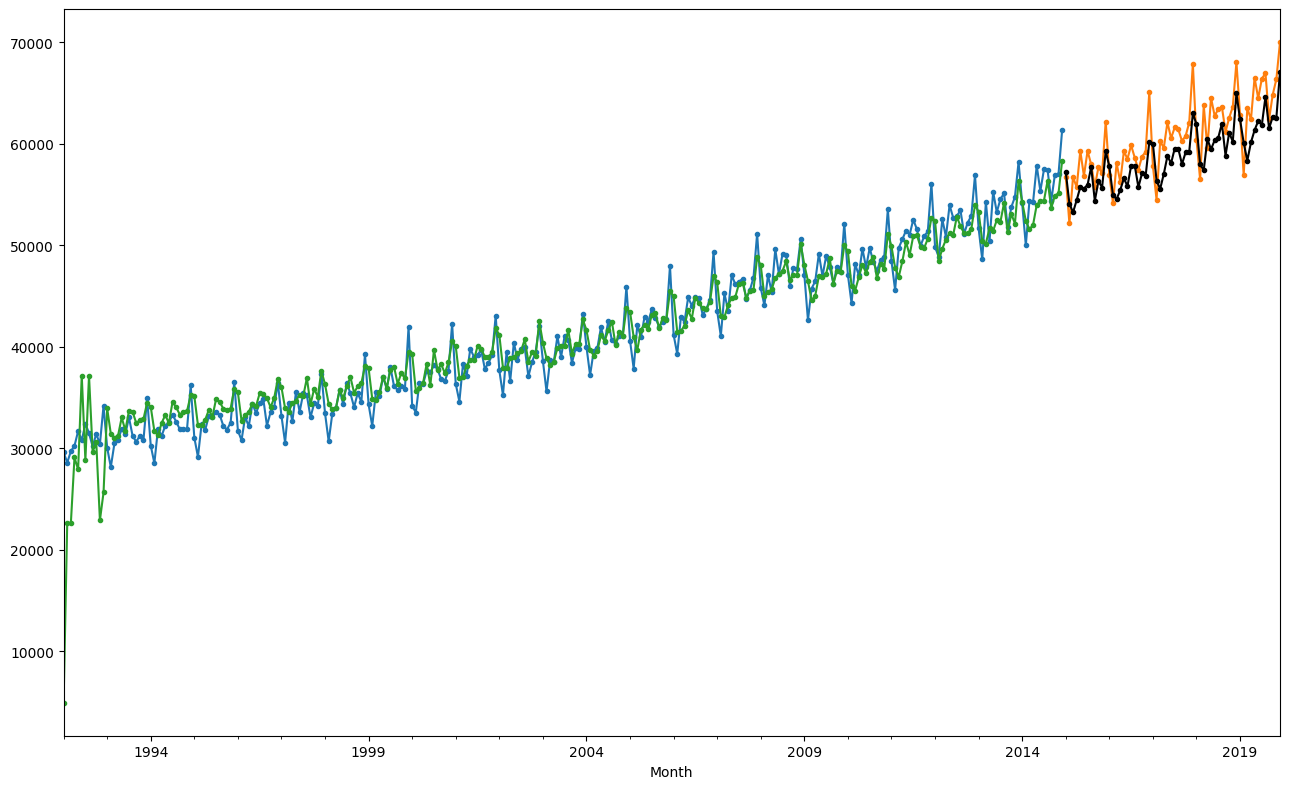

In [70]:
#predecimos

# Create target series and data splits
y = food.FoodAndBeverage.copy()
X_train, X_test, y_train, y_test = train_test_split(food_lag, y, test_size=60, shuffle=False)

# Fit and predict
model_lr_lag_food = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model_lr_lag_food.fit(X_train, y_train)
y_pred = pd.Series(model_lr_lag_food.predict(X_train), index=y_train.index)
y_fore = pd.Series(model_lr_lag_food.predict(X_test), index=y_test.index)

#Metrics
mse_lag_food = mean_squared_error(y_test, y_fore, squared=False)
r2_lag_food = model_lr_lag_food.score(X_test, y_test)

print(f'MSE FoodAndBeverage: {mse_lag_food}')
print(f'R2 Score FoodAndBeverage: {r2_lag_food}')

#plot
ax = y_train.plot(style='.-')
ax = y_test.plot(style='.-')
ax = y_pred.plot(ax=ax, style='.-')
_ = y_fore.plot(ax=ax, color='black', style='.-')

Volviendo al gráfico de autocorrelación parcial para Automobiles, sugiere que la dependencia puede capturarse utilizando los lags 1,2,7,9 y 12

In [71]:
auto = pd.DataFrame(retail.Sales.Automobiles)
auto

,Automobiles
Month,
1992-01,26788
1992-02,28203
1992-03,31684
1992-04,32547
1992-05,32883
...,...
2019-08,105884
2019-09,91758
2019-10,95219


In [72]:
auto_lag = make_lags(auto, lags=2)
auto_lag = auto_lag.fillna(0.0)
auto_lag

,y_lag_1,y_lag_2
,Automobiles,Automobiles
Month,,
1992-01,0.0,0.0
1992-02,26788.0,0.0
1992-03,28203.0,26788.0
1992-04,31684.0,28203.0
1992-05,32547.0,31684.0
...,...,...
2019-08,100703.0,96499.0
2019-09,105884.0,100703.0


MSE Automobiles: 14144.545574686146
R2 Score Automobiles: -2.6699517694334953


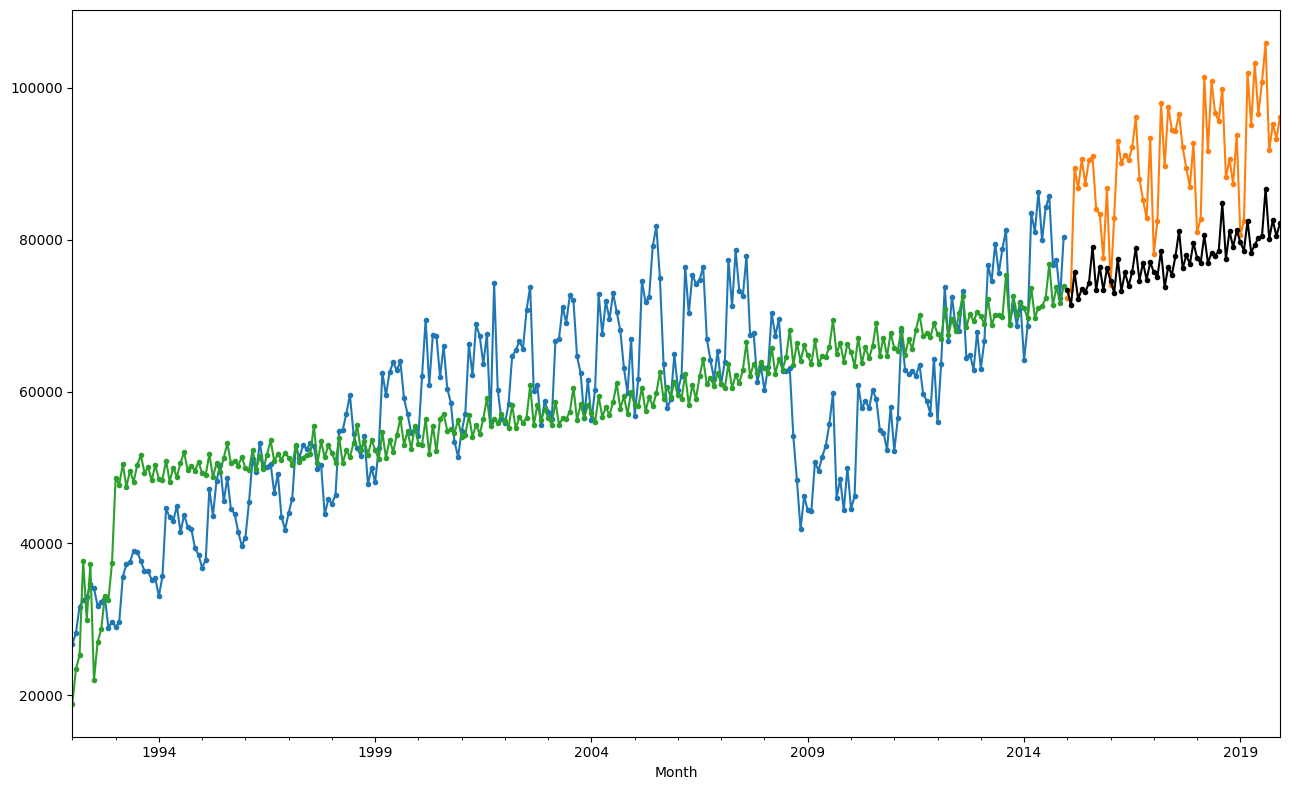

In [73]:
#predict
# Create target series and data splits
y = auto.Automobiles.copy()
X_train, X_test, y_train, y_test = train_test_split(food_lag, y, test_size=60, shuffle=False)

# Fit and predict
model_lr_lag_auto = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model_lr_lag_auto.fit(X_train, y_train)
y_pred = pd.Series(model_lr_lag_auto.predict(X_train), index=y_train.index)
y_fore = pd.Series(model_lr_lag_auto.predict(X_test), index=y_test.index)

#Metrics
mse_lag_auto = mean_squared_error(y_test, y_fore, squared=False)
r2_lag_auto =  model_lr_lag_auto.score(X_test, y_test)

print(f'MSE Automobiles: {mse_lag_auto}')
print(f'R2 Score Automobiles: {r2_lag_auto}')

#plot
ax = y_train.plot(style='.-')
ax = y_test.plot(style='.-')
ax = y_pred.plot(ax=ax, style='.-')
_ = y_fore.plot(ax=ax, color='black', style='.-')

## Estrategias de multi-paso para forecasting

Aplicaremos las estrategias MultiOutput y Direct a los datos, realizando previsiones reales para varios meses más allá del periodo de entrenamiento.


Definiremos nuestra tarea de previsión con un horizonte de 12 meses y un lead time de 1 mes. En otras palabras, pronosticaremos 12 meses de ventas para las indistrias 'FoodAndBeverage' y 'Automobiles' a partir del mes siguiente.

En primer lugar, prepararemos nuestra serie objetivo para la predicción en varios pasos para FoodAndBeverage. Una vez hecho esto, el entrenamiento y la predicción serán muy sencillos.


Utilizaremos la regresión lineal como estrategia MultiOutput. Una vez que tenemos nuestros datos preparados para múltiples salidas, el entrenamiento y la predicción es igual que siempre.


In [74]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [75]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# 8 meses de lag features
y = retail.Sales.FoodAndBeverage.copy()
X = make_lags(y, lags=8).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# forecast de 12 meses
y = make_multistep_target(y, steps=12).dropna()

# El desplazamiento ha creado índices que no coinciden. Mantenemos sólo los tiempos para
# que tenemos tanto objetivos como características.
y, X = y.align(X, join='inner', axis=0)



# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

lr_mo_food = LinearRegression()
lr_mo_food.fit(X_train, y_train)

y_fit = pd.DataFrame(lr_mo_food.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(lr_mo_food.predict(X_test), index=X_test.index, columns=y.columns)

Un modelo de varios pasos producirá una previsión completa para cada instancia utilizada como entrada. Hay 246 meses en el conjunto de entrenamiento y 83 meses en el conjunto de prueba, y ahora tenemos una previsión de 12 pasos para cada uno de estos meses.

Train RMSE FoodAndBeverage: 51.24
Test RMSE FoodAndBeverage: 57.20
R2 Score FoodAndBeverage: 0.37431972972396826


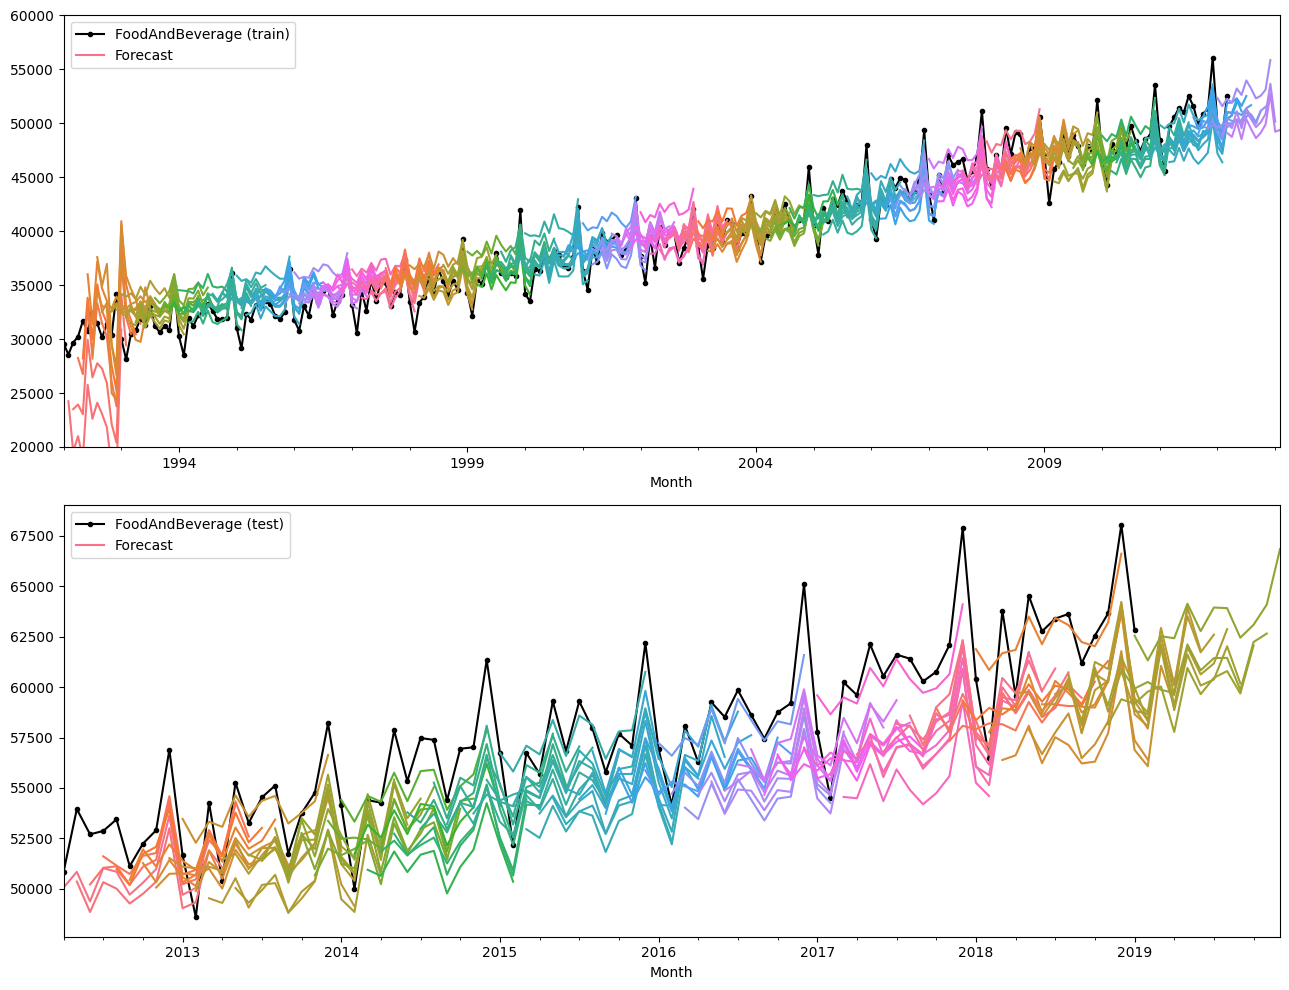

In [76]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_fit, squared=False))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
r2_mo_food = lr_mo_food.score(X_test, y_test)
print((f"Train RMSE FoodAndBeverage: {train_rmse:.2f}\n" f"Test RMSE FoodAndBeverage: {test_rmse:.2f}"))
print(f'R2 Score FoodAndBeverage: {r2_mo_food}')

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10))
ax1 = retail.Sales.FoodAndBeverage[y_fit.index].plot(style='.-', ax=ax1, color='black')
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FoodAndBeverage (train)', 'Forecast'])
_ = ax1.set_ylim(20000,60000)
ax2 = retail.Sales.FoodAndBeverage[y_pred.index].plot(style='.-',ax=ax2, color='black' )
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FoodAndBeverage (test)', 'Forecast'])

El mismo procedimiento para Automobiles

In [77]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# 2 meses de lag features
y = retail.Sales.Automobiles.copy()
X = make_lags(y, lags=2).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# forecast de 12 meses
y = make_multistep_target(y, steps=12).dropna()

# El desplazamiento ha creado índices que no coinciden. Mantenemos sólo los tiempos para
# que tenemos tanto objetivos como características.
y, X = y.align(X, join='inner', axis=0)



# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

lr_mo_auto = LinearRegression()
lr_mo_auto.fit(X_train, y_train)

y_fit = pd.DataFrame(lr_mo_auto.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(lr_mo_auto.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE Automobiles: 82.47
Test RMSE Automobiles: 102.99
R2 Score Automobiles: -0.1640652149637736


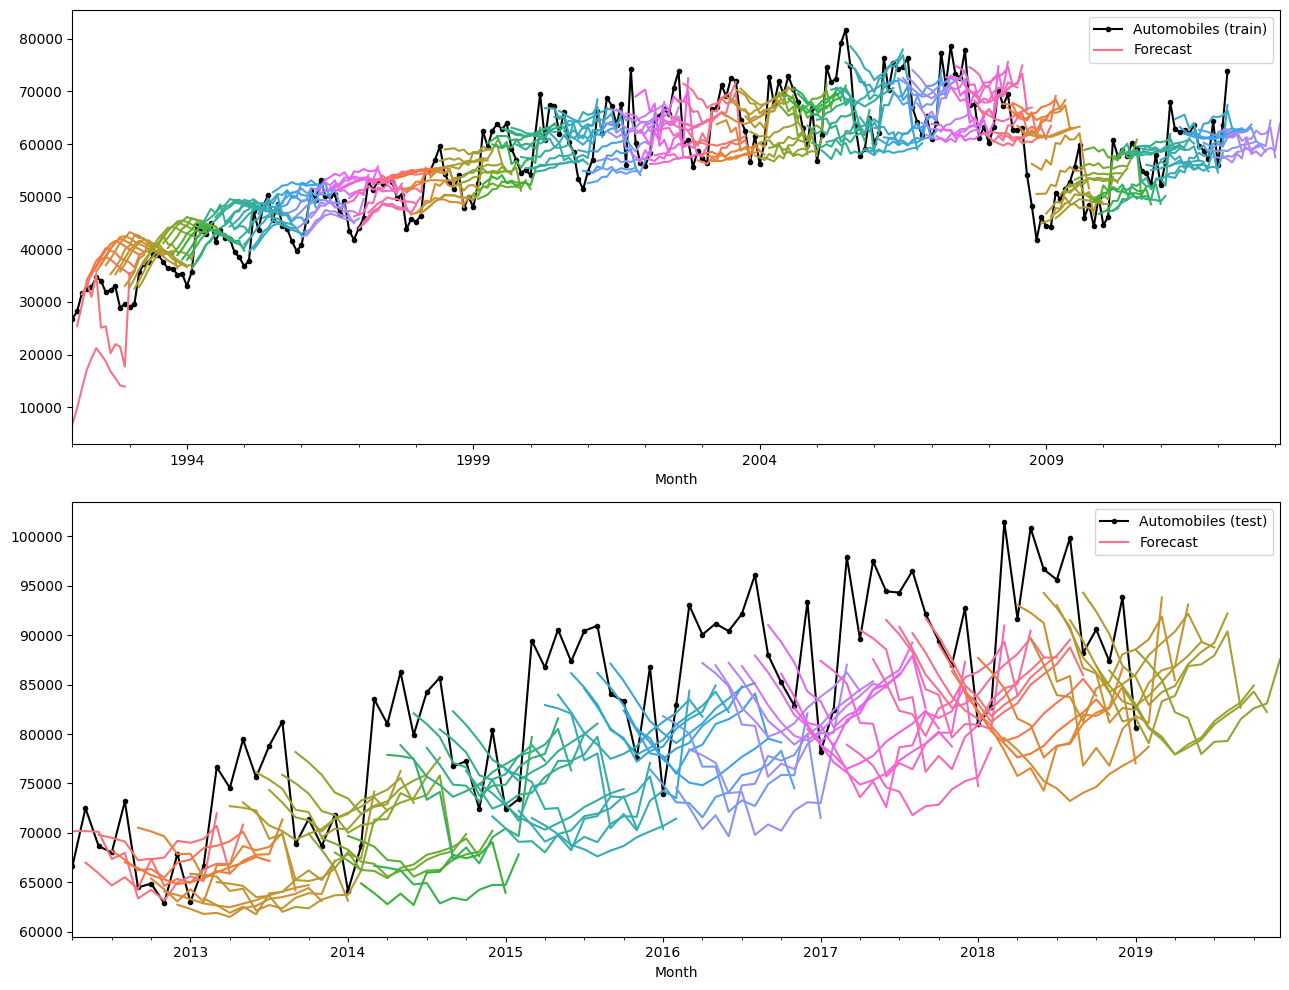

In [78]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_fit, squared=False))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
r2_mo_auto = lr_mo_auto.score(X_test, y_test)
print((f"Train RMSE Automobiles: {train_rmse:.2f}\n" f"Test RMSE Automobiles: {test_rmse:.2f}"))
print(f'R2 Score Automobiles: {r2_mo_auto}')

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10))
ax1 = retail.Sales.Automobiles[y_fit.index].plot(style='.-', ax=ax1, color='black')
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Automobiles (train)', 'Forecast'])
ax2 = retail.Sales.Automobiles[y_pred.index].plot(style='.-',ax=ax2, color='black' )
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Automobiles (test)', 'Forecast'])

### Estrategia Direct

XGBoost no puede producir salidas múltiples para tareas de regresión. Pero mediante la aplicación de la estrategia de reducción directa, todavía podemos utilizarlo para producir pronósticos de varios pasos. Esto es tan fácil como envolverlo con MultiOutputRegressor de scikit-learn.


In [79]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# 8 meses de lag features
y = retail.Sales.FoodAndBeverage.copy()
X = make_lags(y, lags=8).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# forecast de 12 meses
y = make_multistep_target(y, steps=12).dropna()

# El desplazamiento ha creado índices que no coinciden. Mantenemos sólo los tiempos para
# que tenemos tanto objetivos como características.
y, X = y.align(X, join='inner', axis=0)



# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

xgb_mo_food = XGBRegressor()
xgb_mo_food.fit(X_train, y_train)

y_fit = pd.DataFrame(xgb_mo_food.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(xgb_mo_food.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE FoodAndBeverage: 1.47
Test RMSE FoodAndBeverage: 77.82
R2 Score FoodAndBeverage: -1.227825690381793


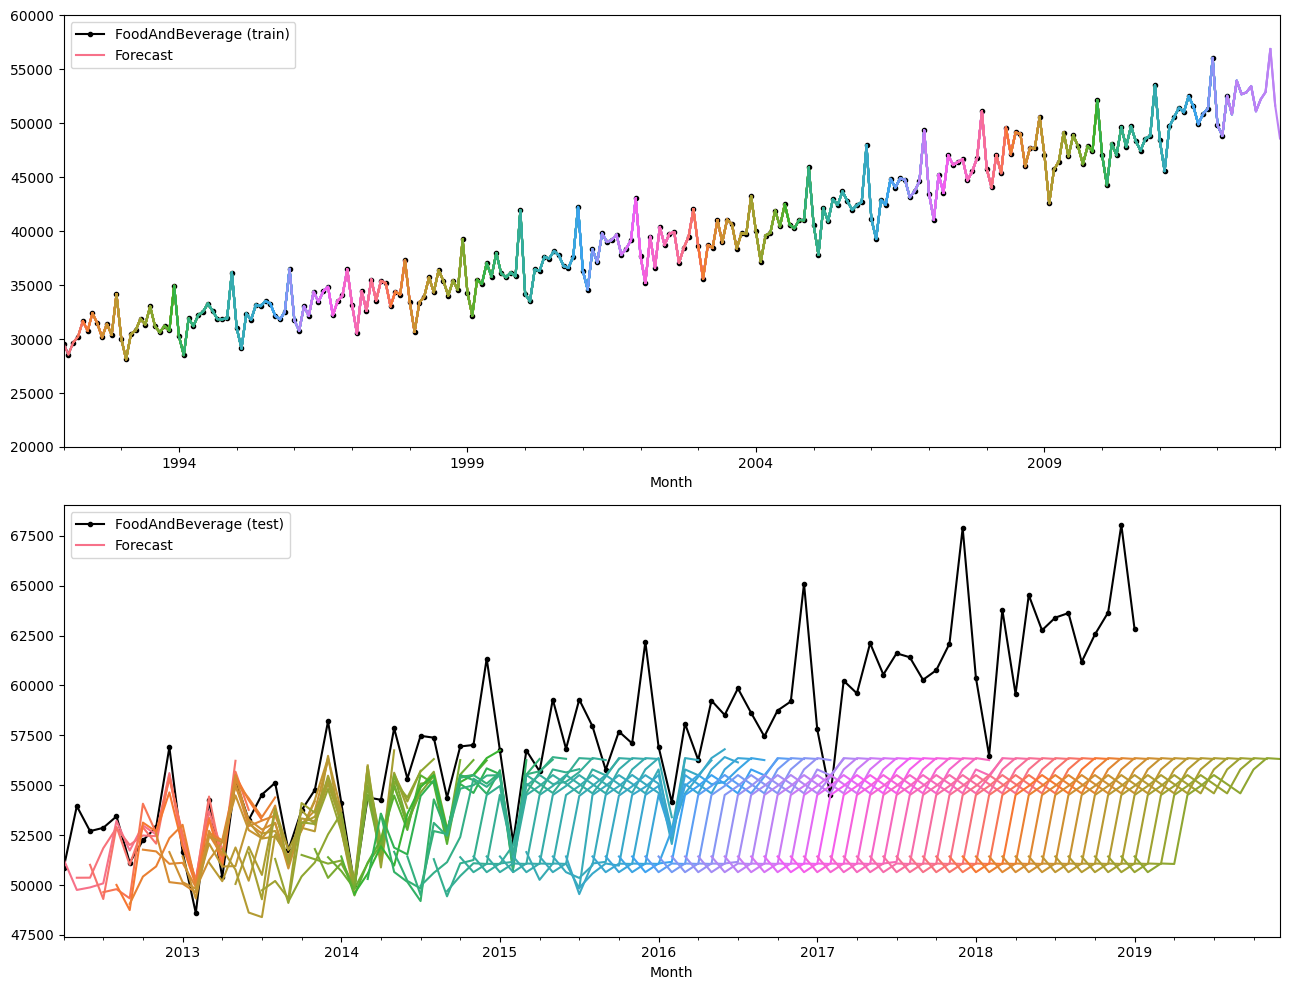

In [80]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_fit, squared=False))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
r2_mo_food = r2_score(y_test, y_pred)
print((f"Train RMSE FoodAndBeverage: {train_rmse:.2f}\n" f"Test RMSE FoodAndBeverage: {test_rmse:.2f}"))
print(f'R2 Score FoodAndBeverage: {r2_mo_food}')

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10))
ax1 = retail.Sales.FoodAndBeverage[y_fit.index].plot(style='.-', ax=ax1, color='black')
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FoodAndBeverage (train)', 'Forecast'])
_ = ax1.set_ylim(20000,60000)
ax2 = retail.Sales.FoodAndBeverage[y_pred.index].plot(style='.-',ax=ax2, color='black' )
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FoodAndBeverage (test)', 'Forecast'])

In [81]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# 2 meses de lag features
y = retail.Sales.Automobiles.copy()
X = make_lags(y, lags=2).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# forecast de 12 meses
y = make_multistep_target(y, steps=12).dropna()

# El desplazamiento ha creado índices que no coinciden. Mantenemos sólo los tiempos para
# que tenemos tanto objetivos como características.
y, X = y.align(X, join='inner', axis=0)



# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

xgb_mo_auto = XGBRegressor()
xgb_mo_auto.fit(X_train, y_train)

y_fit = pd.DataFrame(xgb_mo_auto.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(xgb_mo_auto.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE Automobiles: 15.51
Test RMSE Automobiles: 143.52
R2 Score Automobiles: -1.227825690381793


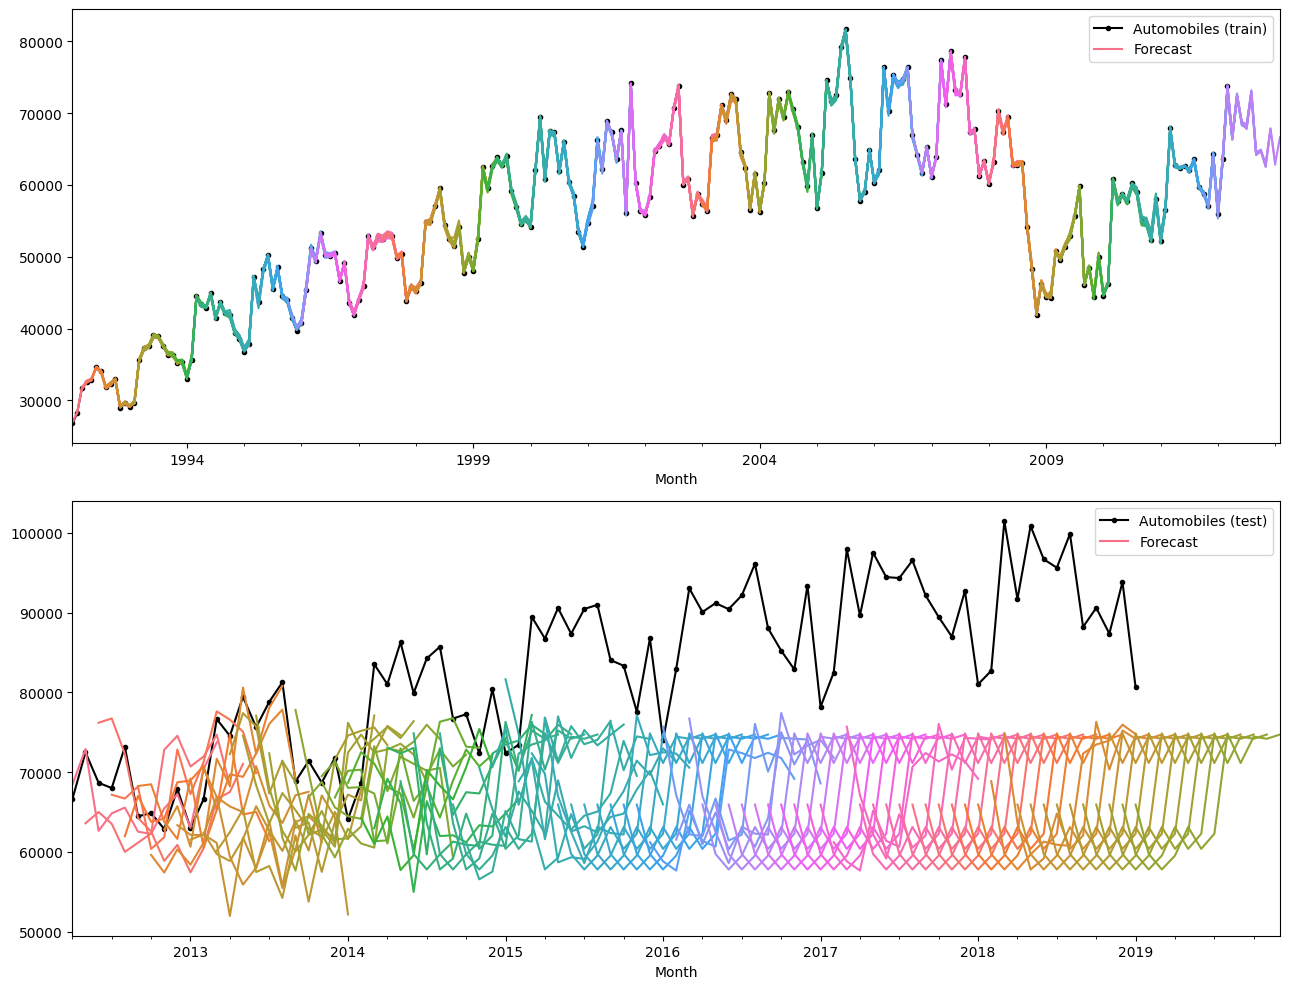

In [82]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_fit, squared=False))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
r2_mo_auto = r2_score(y_test, y_pred)
print((f"Train RMSE Automobiles: {train_rmse:.2f}\n" f"Test RMSE Automobiles: {test_rmse:.2f}"))
print(f'R2 Score Automobiles: {r2_mo_food}')

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10))
ax1 = retail.Sales.Automobiles[y_fit.index].plot(style='.-', ax=ax1, color='black')
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Automobiles (train)', 'Forecast'])
ax2 = retail.Sales.Automobiles[y_pred.index].plot(style='.-',ax=ax2, color='black' )
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Automobiles (test)', 'Forecast'])